In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import yfinance as yf
import pandas as pd
from pmdarima.arima import auto_arima

# Train an automatic ARIMA model
def train_auto_arima_model(data):
    model = auto_arima(data, suppress_warnings=True, stepwise=True, seasonal=False, error_action="ignore")
    return model

# Get stock price and fundamental data
def get_stock_and_fundamental_data(symbols, start_date, end_date):
    stock_data = yf.download(symbols, start=start_date, end=end_date)
    fundamental_data = {}
    
    for symbol in symbols:
        fundamental_data[symbol] = yf.Ticker(symbol)
        
    resampled_fundamental_data = {}
    
    for symbol in symbols:
        data = fundamental_data[symbol].history(period="1d", start=start_date, end=end_date)
        
        data.index = data.index.tz_localize(None)
        data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
        data = data.fillna(method='ffill')
        
        resampled_fundamental_data[symbol] = data

    merged_data = pd.concat([stock_data, *resampled_fundamental_data.values()], axis=1)
    
    auto_arima_models = {}
    
    for symbol in symbols:
        if ('Close', symbol) in merged_data.columns:
            stock_price_data = merged_data[('Close', symbol)].dropna()
            auto_arima_model = train_auto_arima_model(stock_price_data)
            merged_data[('AutoARIMA', symbol)] = auto_arima_model.predict_in_sample()
            auto_arima_models[symbol] = auto_arima_model

    # Calculate the percentage change in closing price (return)
    for symbol in symbols:
        merged_data[('1M_Return', symbol)] = merged_data[('Close', symbol)].pct_change(periods=20)
        merged_data[('2M_Return', symbol)] = merged_data[('Close', symbol)].pct_change(periods=40)
        merged_data[('3M_Return', symbol)] = merged_data[('Close', symbol)].pct_change(periods=60)

    # Calculate historical volatility
    for symbol in symbols:
        merged_data[('1M_Volatility', symbol)] = merged_data[('Close', symbol)].rolling(window=20).std()
        merged_data[('2M_Volatility', symbol)] = merged_data[('Close', symbol)].rolling(window=40).std()
        merged_data[('3M_Volatility', symbol)] = merged_data[('Close', symbol)].rolling(window=60).std()

    # Calculate the percentage deviation from the moving average
    for symbol in symbols:
        merged_data[('10D_MA_Deviation', symbol)] = (merged_data[('Close', symbol)] - merged_data[('Close', symbol)].rolling(window=10).mean()) / merged_data[('Close', symbol)].rolling(window=10).mean()
        merged_data[('50D_MA_Deviation', symbol)] = (merged_data[('Close', symbol)] - merged_data[('Close', symbol)].rolling(window=50).mean()) / merged_data[('Close', symbol)].rolling(window=50).mean()
        merged_data[('200D_MA_Deviation', symbol)] = (merged_data[('Close', symbol)] - merged_data[('Close', symbol)].rolling(window=200).mean()) / merged_data[('Close', symbol)].rolling(window=200).mean()

    return merged_data

# Examples ; Apple, Microsoft
symbols = ['AAPL', 'MSFT']  
start_date = '2023-01-01'
end_date = '2023-12-31'

result = get_stock_and_fundamental_data(symbols, start_date, end_date)
print(result)


[*********************100%%**********************]  2 of 2 completed
            (Adj Close, AAPL)  (Adj Close, MSFT)  (Close, AAPL)  \
Date                                                              
2023-01-03         124.538658         237.956329     125.070000   
2023-01-04         125.823189         227.547363     126.360001   
2023-01-05         124.488869         220.803360     125.019997   
2023-01-06         129.069336         223.405609     129.619995   
2023-01-09         129.597076         225.580765     130.149994   
...                       ...                ...            ...   
2023-10-10         178.389999         328.390015     178.389999   
2023-10-11         179.800003         332.420013     179.800003   
2023-10-12         180.710007         331.160004     180.710007   
2023-10-13         178.850006         327.730011     178.850006   
2023-10-16         178.720001         332.640015     178.720001   

            (Close, MSFT)  (High, AAPL)  (High, MSFT)  (Low

In [4]:
import yfinance as yf
import pandas as pd
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
import numpy as np

# Train an automatic ARIMA model
def train_auto_arima_model(data):
    model = auto_arima(data, suppress_warnings=True, stepwise=True, seasonal=False, error_action="ignore")
    return model

# Time series cross-validation
def time_series_cross_validation(result, train_size, test_size, step_size, symbol):
    n = len(result)
    start_idx = 0
    end_idx = train_size

    while end_idx + test_size <= n:
        # Train data (converted to 1D series)
        train_data = result.iloc[start_idx:end_idx][('Close', symbol)].dropna()
        # Test data (converted to 1D series)
        test_data = result.iloc[end_idx:end_idx + test_size][('Close', symbol)].dropna()

        # Automatic ARIMA model training
        model = train_auto_arima_model(train_data)

        # Prediction by model
        predictions = model.predict(n_periods=test_size)

        # Model Evaluation
        rmse = np.sqrt(mean_squared_error(test_data, predictions))
        print(f"RMSE for {symbol}: {rmse}")

        start_idx += step_size
        end_idx += step_size

# Examples ; Apple, Microsoft
symbols = ['AAPL', 'MSFT']  
start_date = '2023-01-01'
end_date = '2023-12-31'

result = get_stock_and_fundamental_data(symbols, start_date, end_date)

# Perform time series cross-validation for each symbol
for symbol in symbols:
    time_series_cross_validation(result, 100, 10, 10, symbol)



[*********************100%%**********************]  2 of 2 completed


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for AAPL: 3.5062722019282115


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for AAPL: 1.8135824251426211


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for AAPL: 3.688584966325576


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for AAPL: 2.94708497873424


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for AAPL: 10.026287120600793


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for AAPL: 3.3192596586324314


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for AAPL: 7.956854043270077


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for AAPL: 6.253037126817244


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for AAPL: 3.140374025274986


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for MSFT: 5.62057887330505


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for MSFT: 7.980329091251963


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for MSFT: 5.464624630503476


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for MSFT: 15.949420317582643


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for MSFT: 26.74690908350477


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for MSFT: 5.560543253557107


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for MSFT: 6.341818401870224


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for MSFT: 5.174814634984856
RMSE for MSFT: 5.469023439400305


C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\takum\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [31]:
import yfinance as yf
import pandas as pd
from pmdarima.arima import auto_arima
import numpy as np

# Train an automatic ARIMA model
def train_auto_arima_model(data):
    model = auto_arima(data, suppress_warnings=True, stepwise=True, seasonal=False, error_action="ignore")
    return model

# Get stock price and fundamental data
def get_stock_and_fundamental_data(symbols, start_date, end_date):
    data = {}  # Dictionary for storing data

    for symbol in symbols:
        # Get stock price data using yfinance
        stock_data = yf.download(symbol, start=start_date, end=end_date)
        
        # Extract the data you need (in this example, only the closing price)
        data[symbol] = stock_data['Close']

    # Convert data to Pandas DataFrame
    result = pd.DataFrame(data)
    
    return result

# Examples ; Apple, Microsoft
symbols = ['AAPL', 'MSFT']  
start_date = '2023-01-01'
end_date = '2023-12-31'

result = get_stock_and_fundamental_data(symbols, start_date, end_date)

# Get ARIMA output results (predictions)
arima_predictions = result['AAPL'].values  

# Set LSTM input data window size
window_size = 10  # As an example, consider data for the past 10 days.

# Initialize LSTM input and output data
X_data = []
y_data = []

    
# Initialize LSTM input and output data
X_data = []
y_data = []

# Loop over dataset
for i in range(len(arima_predictions) - window_size):
    # Input data including past observations
    input_sequence = arima_predictions[i:i+window_size]

    # Add corresponding predictions as output data
    if i + window_size < len(arima_predictions):
        y_data.append(arima_predictions[i + window_size])

    # Add as LSTM input data
    X_data.append(input_sequence)


# Convert input and output data to NumPy array
X_data = np.array(X_data)
y_data = np.array(y_data)

# X_data is a 3D array whose shape is (number of data points, window size)
# y_data is a 1D array of shape (number of data points,)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [34]:
# Change from 2D data to 3D data
X_data = np.array(X_data)
X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], 1)  # Add last dimension

# Define a MinMaxScaler for the future data
scaler = MinMaxScaler()

# Define a MinMaxScaler for the input data (X_data)
scalers = [MinMaxScaler() for _ in range(X_data.shape[2])]
X_data_normalized = np.empty_like(X_data)

# Normalize the input data
for feature in range(X_data.shape[2]):
    X_data_normalized[:, :, feature] = scalers[feature].fit_transform(X_data[:, :, feature])

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_data.shape[1], X_data.shape[2])))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_data_normalized, y_data, epochs=50, batch_size=32)

# Get the future data (assuming arima_predictions is already defined)
future_data = arima_predictions[-window_size:]  # Get the last window

# Normalize the future data
future_data = future_data.reshape(-1, 1)  # Reshape the data to (10, 1)
future_data_normalized = scaler.fit_transform(future_data)

# Reshape it for the LSTM model
future_data_normalized = future_data_normalized.reshape(1, future_data_normalized.shape[0], 1)  # Reshape the data to (1, 10, 1)

# Use the LSTM model to make future predictions
predicted_value = model.predict(future_data_normalized)

# Inverse transform to the original scale
predicted_value = scaler.inverse_transform(predicted_value)


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 29480.7188
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 29402.8516
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 29308.3066
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 29166.3730
Epoch 5/50
6/6 [==============================] - 0s 5ms/step - loss: 28922.3965
Epoch 6/50
6/6 [==============================] - 0s 5ms/step - loss: 28488.8301
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 27882.7832
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 27286.5020
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 26792.4570
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 26407.7617
Epoch 11/50
6/6 [==============================] - 0s 6ms/step - loss: 26104.6445
Epoch 12/50
6/6 [==============================] - 0s 5ms/step - loss: 25861.6562
Epoch 13/50
6/6 [========

In [37]:
print(predicted_value)

[[350.5933]]


In [35]:
print(result.columns)

Index(['AAPL', 'MSFT'], dtype='object')


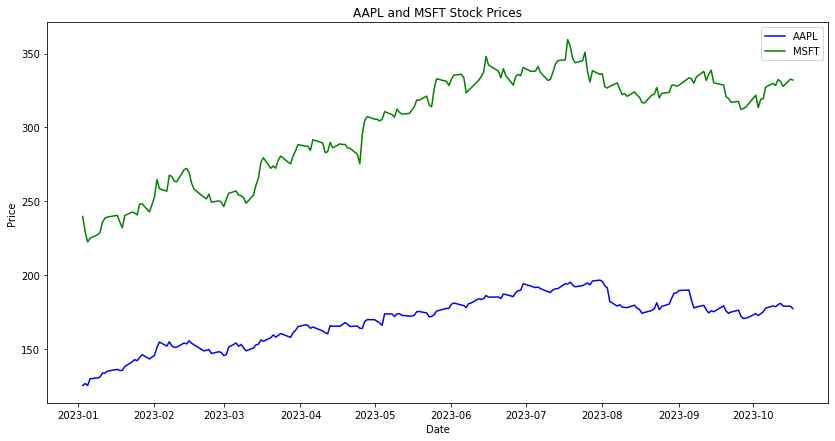

In [38]:
import matplotlib.pyplot as plt

# Extract AAPL and MSFT stock price data
aapl_data = result['AAPL']
msft_data = result['MSFT']

# Set graph size
plt.figure(figsize=(14, 7))

# Drawing AAPL stock price data
plt.plot(aapl_data.index, aapl_data, label='AAPL', color='blue')

# Drawing MSFT stock price data
plt.plot(msft_data.index, msft_data, label='MSFT', color='green')

# Set graph title and axis labels
plt.title('AAPL and MSFT Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')

# Show legend
plt.legend()

# Show graph
plt.show()


In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract AAPL and MSFT stock price data
aapl_data = result['AAPL']
msft_data = result['MSFT']

# Set date as index
aapl_data.index = pd.to_datetime(aapl_data.index)
msft_data.index = pd.to_datetime(msft_data.index)

# Delete rows containing missing values
aapl_data.dropna(inplace=True)
msft_data.dropna(inplace=True)

# Create a new data frame, specify column names and calculate moving average
aapl_df = pd.DataFrame({'Close': aapl_data})
msft_df = pd.DataFrame({'Close': msft_data})

aapl_df['10D_MA'] = aapl_df['Close'].rolling(window=10).mean()
aapl_df['50D_MA'] = aapl_df['Close'].rolling(window=50).mean()
aapl_df['200D_MA'] = aapl_df['Close'].rolling(window=200).mean()

msft_df['10D_MA'] = msft_df['Close'].rolling(window=10).mean()
msft_df['50D_MA'] = msft_df['Close'].rolling(window=50).mean()
msft_df['200D_MA'] = msft_df['Close'].rolling(window=200).mean()


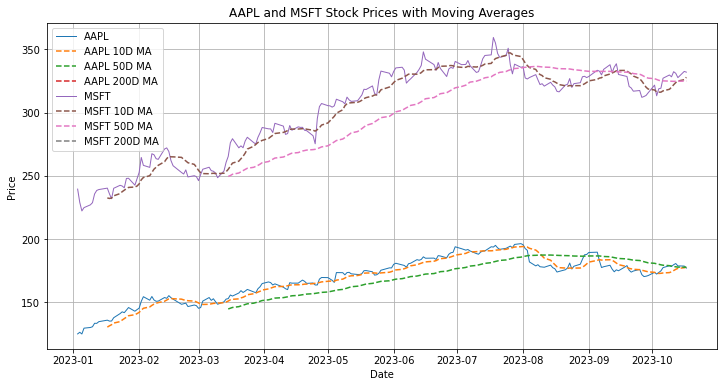

In [68]:
# Draw a graphv
plt.figure(figsize=(12, 6))
plt.plot(aapl_data.index, aapl_data, label='AAPL', linewidth=1)
plt.plot(aapl_df.index, aapl_df['10D_MA'], label='AAPL 10D MA', linestyle='--')
plt.plot(aapl_df.index, aapl_df['50D_MA'], label='AAPL 50D MA', linestyle='--')
plt.plot(aapl_df.index, aapl_df['200D_MA'], label='AAPL 200D MA', linestyle='--')

plt.plot(msft_data.index, msft_data, label='MSFT', linewidth=1)
plt.plot(msft_df.index, msft_df['10D_MA'], label='MSFT 10D MA', linestyle='--')
plt.plot(msft_df.index, msft_df['50D_MA'], label='MSFT 50D MA', linestyle='--')
plt.plot(msft_df.index, msft_df['200D_MA'], label='MSFT 200D MA', linestyle='--')

plt.title('AAPL and MSFT Stock Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [71]:
import numpy as np
import pandas as pd

# Create a function to generate moving average crossover signals
def generate_signals(data, short_window, long_window):
    signals = []

    for i in range(len(data)):
        if i < long_window:
            signals.append(0)  # No signal until the long window is reached
        else:
            short_avg = np.mean(data[i - short_window:i])
            long_avg = np.mean(data[i - long_window:i])

            if short_avg > long_avg:
                signals.append("Buy")  # Generate a Buy signal
            else:
                signals.append("Sell")  # Generate a Sell signal

    return signals

# Define the window sizes for short and long moving averages
short_window = 10  # Adjust this to your preferred short window size
long_window = 50  # Adjust this to your preferred long window size

# Assume you have DataFrames named 'aapl_df' and 'msft_df'
# that contain '10D_MA' and '50D_MA' columns
# You can access these columns as follows: aapl_df['10D_MA'] and msft_df['10D_MA']
# Replace these with your actual DataFrame and column names

# Generate moving average crossover signals for the short and long moving averages of AAPL and MSFT
aapl_signals_10_50 = generate_signals(aapl_df['10D_MA'], short_window, long_window)
msft_signals_10_50 = generate_signals(msft_df['10D_MA'], short_window, long_window)

# Create DataFrames with the signals
aapl_signals_data = pd.DataFrame({
    'AAPL_10D_50D_Signal': aapl_signals_10_50
})

msft_signals_data = pd.DataFrame({
    'MSFT_10D_50D_Signal': msft_signals_10_50
})

# Combine the signals DataFrames with the respective stock DataFrames
aapl_df = pd.concat([aapl_df, aapl_signals_data], axis=1)
msft_df = pd.concat([msft_df, msft_signals_data], axis=1)

# Display the updated DataFrames
print(aapl_df)
print(msft_df)


                          Close  10D_MA  50D_MA  200D_MA AAPL_10D_50D_Signal
2023-01-03 00:00:00  125.070000     NaN     NaN      NaN                 NaN
2023-01-04 00:00:00  126.360001     NaN     NaN      NaN                 NaN
2023-01-05 00:00:00  125.019997     NaN     NaN      NaN                 NaN
2023-01-06 00:00:00  129.619995     NaN     NaN      NaN                 NaN
2023-01-09 00:00:00  130.149994     NaN     NaN      NaN                 NaN
...                         ...     ...     ...      ...                 ...
194                         NaN     NaN     NaN      NaN                Sell
195                         NaN     NaN     NaN      NaN                Sell
196                         NaN     NaN     NaN      NaN                Sell
197                         NaN     NaN     NaN      NaN                Sell
198                         NaN     NaN     NaN      NaN                Sell

[398 rows x 5 columns]
                          Close  10D_MA  50D_MA  200